# Logistic Regression 

Use Case:  Use the Titanic passenger data (name, age, price of ticket, etc) to try to predict the survival chance

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [ ]:
train = pd.read_csv('./../../data/titanic_train.csv')

In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

A bird's eye view of data to see how much data we are missing for various columns.
We are missing a lot of values for Age, and a whole lot of values for Cabin which makes this column not very useful

<Axes: >

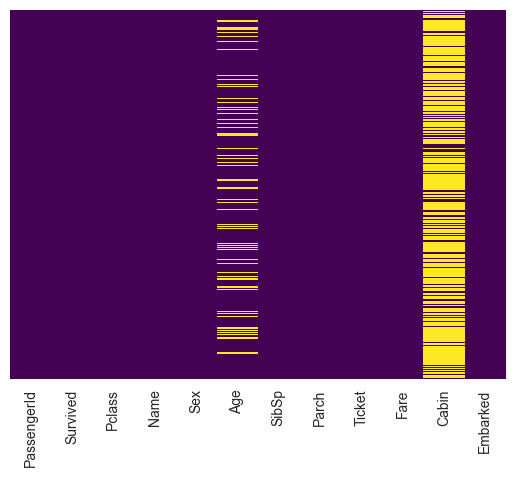

In [45]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Just a quick check on how many people survived or not

/var/folders/5_/t9pglb0n3gddk2f3b46d17sm0000gn/T/ipykernel_82079/1555596437.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='Survived', ylabel='count'>

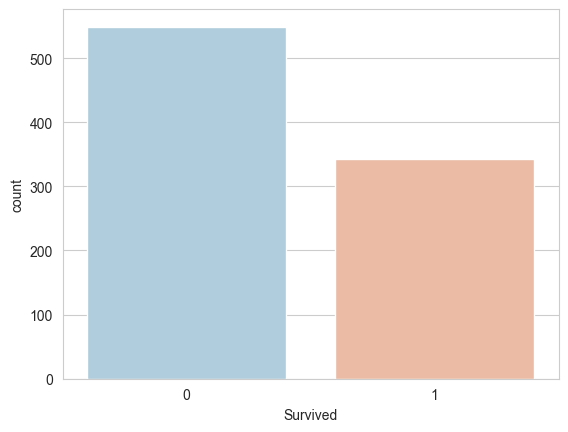

In [46]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

Get the same information based on the gender [female survival rate is higher] 

<Axes: xlabel='Survived', ylabel='count'>

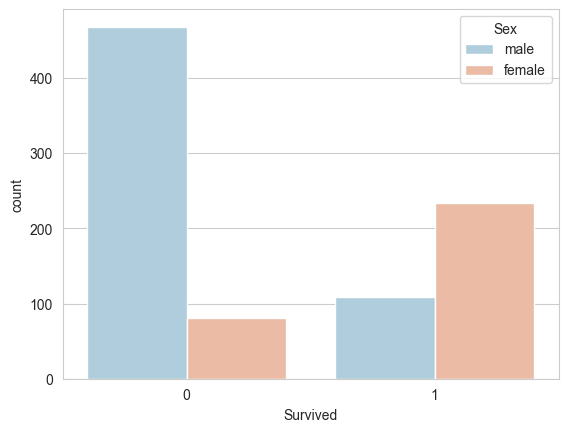

In [47]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

Now, let's see the same distibution based on travel class [People in 1st class have better survival rate]

<Axes: xlabel='Survived', ylabel='count'>

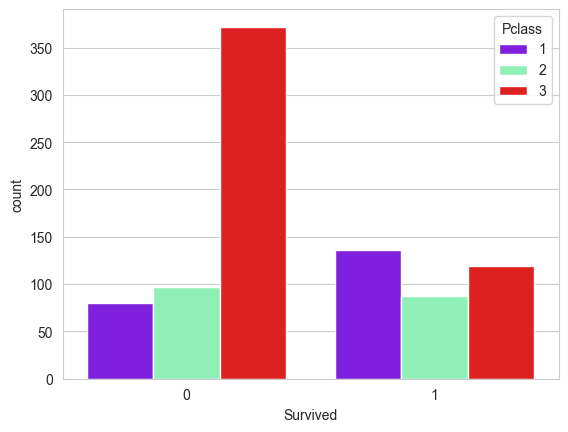

In [48]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

Let's look at the age distribution of the passangers 

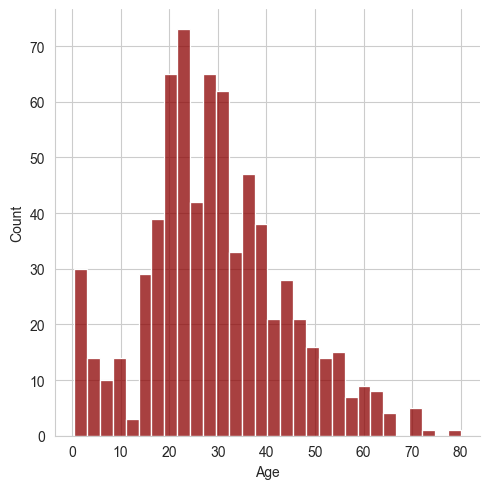

In [49]:
sns.displot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

Let's look at the distribution of the passangers based on the if they are travelling with a sibling/spouse [majority of the people are travelling solo]

<Axes: xlabel='SibSp', ylabel='count'>

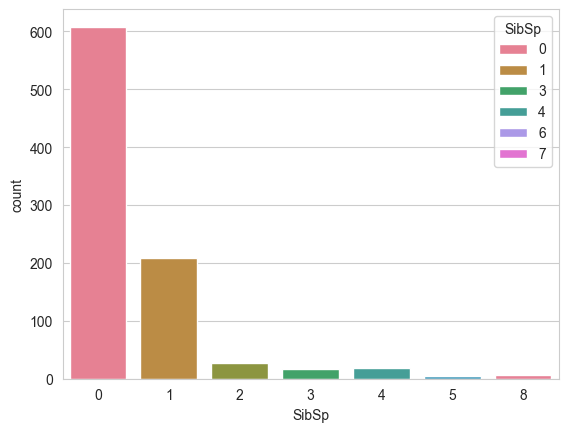

In [50]:
sns.countplot(x='SibSp',data=train, hue='SibSp', palette="husl")

Let's look at the distribution of the passangers based the fare class [majority of the peiople are travelling in 3rd tier]

<Axes: xlabel='Pclass', ylabel='count'>

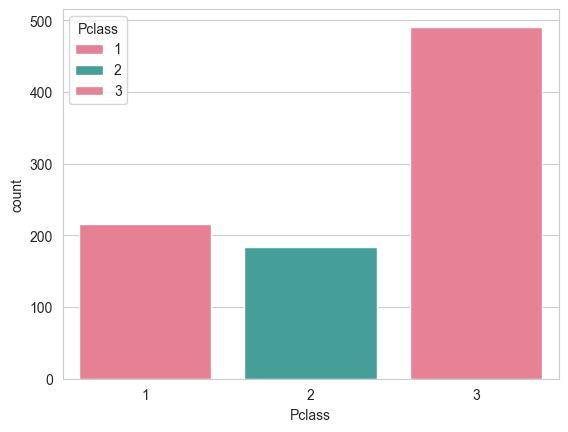

In [51]:
sns.countplot(x='Pclass',data=train, hue='Pclass', palette="husl")

Let's look at the distribution of the passangers based the fare paid [majority of the people paid around 100]

<Axes: xlabel='Fare', ylabel='Count'>

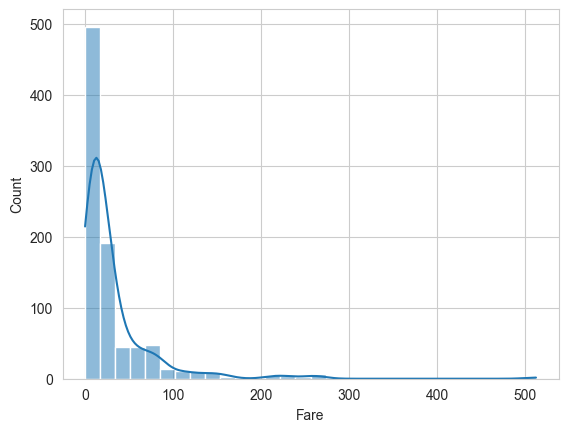

In [52]:
sns.histplot(train['Fare'], bins=30, kde=True)


___
## Data Cleaning
Previously we have seen that there's a lot of missing data for 'Age' and 'Cabin'. We'll discard 'Cabin' as it's missing a lot of data making it not useful.
We'll focus on filling in the missing data for 'Age'. We can simply replace the missing values with the average or we can be a bit more smarter and work with averages based on the 'Pclass' column.
The boxplot below shows the age distribution over the travel class


<Axes: xlabel='Pclass', ylabel='Age'>

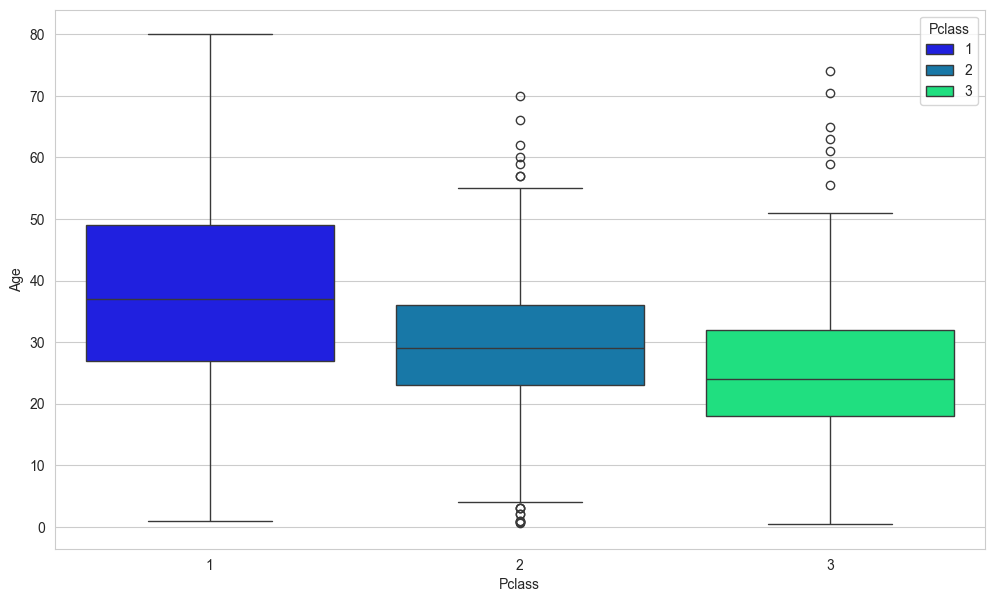

In [53]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,hue="Pclass",palette='winter')

Let's create a function to compute the age for respective class

In [54]:
def fill_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Now apply that function!

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(fill_age,axis=1)

Now let's check that heat map again!

<Axes: >

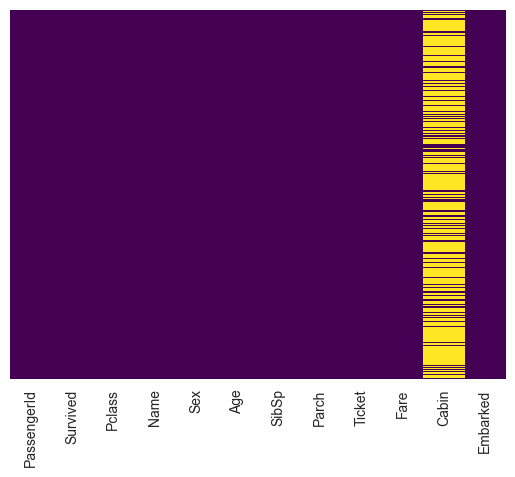

In [56]:
# verify there are no missing values for 'Age'
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [57]:
# Drop the 'Cabin' column since it has too many missing values
train.drop('Cabin',axis=1,inplace=True)

In [58]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.
* Pclass col is also a category type col, but we'll leave it as is for now

In [59]:
sex = pd.get_dummies(train['Sex'],drop_first=True).astype(int)
embark = pd.get_dummies(train['Embarked'],drop_first=True).astype(int)
train = pd.concat([train,sex,embark],axis=1)
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train / Test Split

In [60]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
# We'll use all the columns except 'Survived' as features for our model
X = train.drop('Survived',axis=1)
# Survived is the target variable
y = train['Survived']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), train['Survived'], test_size=0.30, random_state=101)

## Training and Predicting

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

## Evaluation
Let's evaluate the model

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and support (meaning how many cases supported that classification). 

# Classification report
* Precision → How many predicted positives were actually correct?
* Recall → How many actual positives were correctly predicted?
* F1-Score → The trade-off between precision & recall.
* Support → The number of actual occurrences of the class.

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

A dog classifier example. This classifier successfully identified 5 images as containing a dog, but misidentified 3 cats as being dogs.

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/PrecisionrecallDogExample.svg/800px-PrecisionrecallDogExample.svg.png' width=400 />

In [62]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Confusion Matrix
# [ 
#     TP FN
#     FP TN
# ]

print(confusion_matrix(y_test,predictions))

# Classification report
# Precision → How many predicted positives were actually correct?
# Recall → How many actual positives were correctly predicted?
# F1-Score → The trade-off between precision & recall.
# Support → The number of actual occurrences of the class.

print(classification_report(y_test,predictions))
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")


[[147  16]
 [ 30  74]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       163
           1       0.82      0.71      0.76       104

    accuracy                           0.83       267
   macro avg       0.83      0.81      0.81       267
weighted avg       0.83      0.83      0.83       267

Accuracy: 0.83


Not so bad! 
For further exploration: 

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?